In [1]:
import pandas as pd
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
from tqdm import tqdm

# Load your article file
df = pd.read_csv("bitcoin-articles-6y.csv")

# Load FinBERT (PyTorch version)
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Set up FinBERT sentiment pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    framework="pt"  # Ensure PyTorch backend
)

# Prepare result containers
sentiments = []
confidences = []
sentiment_scores = []

print("🔍 Starting sentiment analysis on article titles...")

for title in tqdm(df['title'], desc="Analyzing Sentiment"):
    try:
        result = sentiment_pipeline(title)[0]
        label = result['label'].lower()
        confidence = result['score']

        sentiments.append(label)
        confidences.append(confidence)

        # Weighted score: +prob, –prob, or 0
        if label == "positive":
            sentiment_scores.append(+confidence)
        elif label == "negative":
            sentiment_scores.append(-confidence)
        else:
            sentiment_scores.append(0.0)

    except Exception as e:
        print(f"❌ Error processing: {title} → {e}")
        sentiments.append("error")
        confidences.append(0.0)
        sentiment_scores.append(0.0)

# Add columns to DataFrame
df['sentiment'] = sentiments
df['confidence'] = confidences
df['sentiment_score'] = sentiment_scores

# Save article-level sentiment output
df.to_csv("articles_with_sentiment.csv", index=False)
print("✅ Saved article-level results to 'articles_with_sentiment.csv'")

# Convert date to datetime.date
df['date'] = pd.to_datetime(df['date']).dt.date

# Aggregate daily average sentiment
daily_sentiment = df.groupby('date')['sentiment_score'].mean().reset_index()
daily_sentiment.columns = ['date', 'daily_sentiment_score']
daily_sentiment.to_csv("bitcoin-daily_sentiment.csv", index=False)
print("✅ Saved daily average sentiment to 'bitcoin_sentiment.csv'")


Device set to use cpu


🔍 Starting sentiment analysis on article titles...


Analyzing Sentiment:   0%|          | 35/41588 [00:01<34:09, 20.28it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Analyzing Sentiment:   2%|▏         | 813/41588 [00:39<28:29, 23.86it/s]C:\Users\Korisnik\Documents\Python\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Korisnik\.cache\huggingface\hub\models--ProsusAI--finbert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Analyzing Sentiment: 100%|██████████| 4158

✅ Saved article-level results to 'articles_with_sentiment.csv'
✅ Saved daily average sentiment to 'bitcoin_sentiment.csv'


In [3]:
pip install yfinance

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ------------------------------------- 949.2/949.2 kB 11.1 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 10.8 MB/s eta 0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15617 sha256=273ad9ba10dd01137a0889c87635b0a6603711e4550a38e15a98351fe0b0d0c6
  Stored in directory: c:\users\korisnik\appdata\local\pip\cache\wheels\cc\bd\6f\664d62c99327abeef7d86489e

In [4]:
import yfinance as yf

# Define Bitcoin ticker and date range
start_date = "2019-10-01"
end_date = "2025-10-01"

# Download daily closing prices for Bitcoin (USD)
btc = yf.download("BTC-USD", start=start_date, end=end_date)
btc = btc[['Close']].reset_index()
btc.columns = ['date', 'btc_close']

print("✅ Downloaded Bitcoin price data:", btc.shape)


C:\Users\Korisnik\AppData\Local\Temp\ipykernel_14968\3913562767.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

✅ Downloaded Bitcoin price data: (2192, 2)


In [7]:
# Ensure sentiment sign consistency
df['sentiment_score'] = df.apply(
    lambda x: +x['confidence'] if x['sentiment'] == 'positive'
    else (-x['confidence'] if x['sentiment'] == 'negative' else 0.0),
    axis=1
)

# Recalculate daily average sentiment with signed values
daily_sentiment = df.groupby('date')['sentiment_score'].mean().reset_index()
daily_sentiment.columns = ['date', 'daily_sentiment_score']

# Save clean, signed daily sentiment data
daily_sentiment.to_csv("bitcoin-daily_sentiment.csv", index=False)
print("✅ Recomputed and saved signed daily sentiment to 'bitcoin-daily_sentiment.csv'")


✅ Recomputed and saved signed daily sentiment to 'bitcoin-daily_sentiment.csv'


In [8]:
corr = merged['btc_close'].corr(merged['daily_sentiment_score'])
print(f"📈 Correlation between Bitcoin price and sentiment: {corr:.3f}")


📈 Correlation between Bitcoin price and sentiment: 0.557


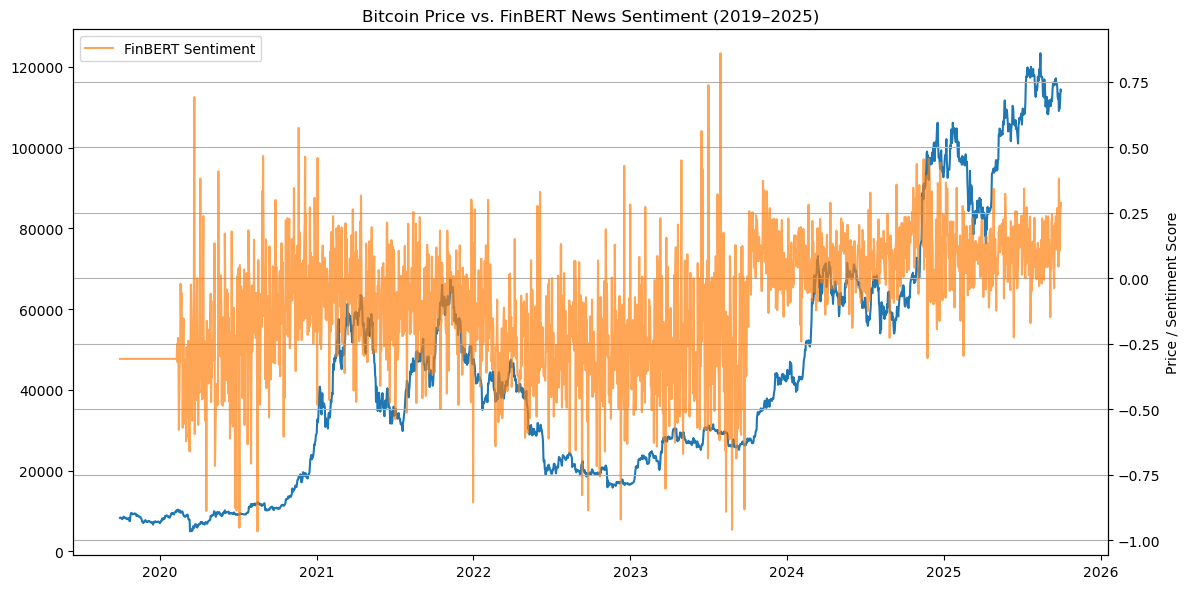

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Left axis: Bitcoin price
plt.plot(merged['date'], merged['btc_close'], label='Bitcoin Price (USD)', color='tab:blue')

# Right axis: Daily sentiment
plt.twinx()
plt.plot(merged['date'], merged['daily_sentiment_score'], label='FinBERT Sentiment', color='tab:orange', alpha=0.7)

plt.title("Bitcoin Price vs. FinBERT News Sentiment (2019–2025)")
plt.xlabel("Date")
plt.ylabel("Price / Sentiment Score")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


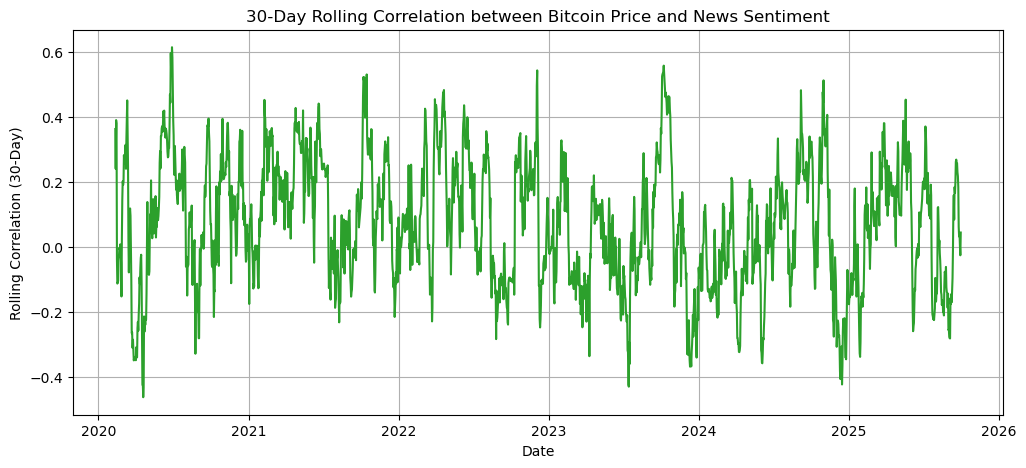

In [10]:
merged['rolling_corr'] = merged['btc_close'].rolling(window=30).corr(merged['daily_sentiment_score'])

plt.figure(figsize=(12, 5))
plt.plot(merged['date'], merged['rolling_corr'], color='tab:green')
plt.title("30-Day Rolling Correlation between Bitcoin Price and News Sentiment")
plt.xlabel("Date")
plt.ylabel("Rolling Correlation (30-Day)")
plt.grid(True)
plt.show()


In [20]:
import numpy as np

# --- Normalize and smooth sentiment before merging ---
# Clip extreme FinBERT scores to [-1, 1]
daily_sentiment['daily_sentiment_score'] = np.clip(daily_sentiment['daily_sentiment_score'], -1, 1)

# Apply a 7-day rolling mean for smoothing (helps visualization)
daily_sentiment['sentiment_smoothed'] = (
    daily_sentiment['daily_sentiment_score']
    .rolling(window=7, min_periods=1)
    .mean()
)

# Normalize to z-scores for better scaling vs. price
daily_sentiment['sentiment_normalized'] = (
    (daily_sentiment['sentiment_smoothed'] - daily_sentiment['sentiment_smoothed'].mean())
    / daily_sentiment['sentiment_smoothed'].std()
)

# Save cleaned version
daily_sentiment.to_csv("bitcoin-daily_sentiment-smoothed.csv", index=False)
print("✅ Added smoothed & normalized sentiment columns.")


✅ Added smoothed & normalized sentiment columns.


In [21]:
merged = pd.merge(btc, daily_sentiment, on='date', how='inner')
print(merged.columns)
# Expected: ['date', 'btc_close', 'daily_sentiment_score', 'sentiment_smoothed', 'sentiment_normalized']


ValueError: You are trying to merge on datetime64[ns] and object columns for key 'date'. If you wish to proceed you should use pd.concat

In [22]:
# Ensure both 'date' columns are in the same datetime64 format
btc['date'] = pd.to_datetime(btc['date']).dt.normalize()  # Normalize to midnight (no time)
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date']).dt.normalize()

# Now safe to merge
merged = pd.merge(btc, daily_sentiment, on='date', how='inner')
print("✅ Merge successful. Shape:", merged.shape)
print(merged.dtypes)


✅ Merge successful. Shape: (2187, 5)
date                     datetime64[ns]
btc_close                       float64
daily_sentiment_score           float64
sentiment_normalized            float64
sentiment_smoothed              float64
dtype: object


In [23]:
merged = pd.merge(btc, daily_sentiment, on='date', how='inner')
print(merged.columns)
# Expected: ['date', 'btc_close', 'daily_sentiment_score', 'sentiment_smoothed', 'sentiment_normalized']


Index(['date', 'btc_close', 'daily_sentiment_score', 'sentiment_normalized',
       'sentiment_smoothed'],
      dtype='object')


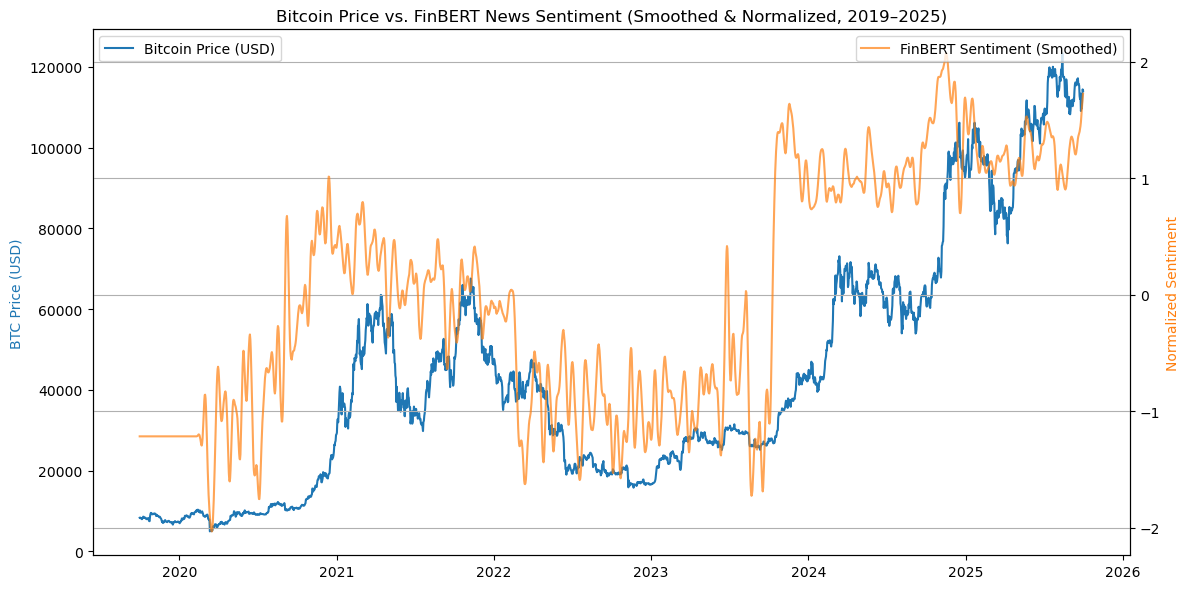

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

ax1 = plt.gca()
ax1.plot(merged['date'], merged['btc_close'], color='tab:blue', label='Bitcoin Price (USD)')
ax1.set_ylabel('BTC Price (USD)', color='tab:blue')

ax2 = ax1.twinx()
ax2.plot(merged['date'], merged['sentiment_normalized'], color='tab:orange', label='FinBERT Sentiment (Smoothed)', alpha=0.7)
ax2.set_ylabel('Normalized Sentiment', color='tab:orange')

plt.title("Bitcoin Price vs. FinBERT News Sentiment (Smoothed & Normalized, 2019–2025)")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
import numpy as np

print(merged[['btc_close', 'sentiment_normalized']].describe())

# Simple correlation and covariance
corr = merged['btc_close'].corr(merged['sentiment_normalized'])
cov = merged['btc_close'].cov(merged['sentiment_normalized'])
print(f"Correlation: {corr:.3f} | Covariance: {cov:.2f}")


           btc_close  sentiment_normalized
count    2187.000000           2187.000000
mean    43384.899927             -0.000809
std     30250.898419              0.999513
min      4970.788086             -2.030890
25%     19620.197266             -0.924384
50%     36825.367188             -0.046162
75%     60938.324219              0.959408
max    123344.062500              2.073468
Correlation: 0.787 | Covariance: 23800.31


In [29]:
from scipy.stats import pearsonr

max_lag = 7  # test ±7 days
results = []

for lag in range(-max_lag, max_lag + 1):
    # shift sentiment forward (positive lag means sentiment leads price)
    shifted = merged['sentiment_normalized'].shift(lag)
    
    # align both series: drop rows with missing values in either
    aligned = merged[['btc_close', 'sentiment_normalized']].copy()
    aligned['sentiment_shifted'] = shifted
    aligned = aligned.dropna(subset=['btc_close', 'sentiment_shifted'])
    
    # compute correlation only on aligned data
    if len(aligned) > 2:
        corr, _ = pearsonr(aligned['btc_close'], aligned['sentiment_shifted'])
        results.append((lag, corr))
        print(f"Lag {lag:+} days → Corr: {corr:.3f}")
    else:
        print(f"Lag {lag:+}: not enough data after alignment")


Lag -7 days → Corr: 0.775
Lag -6 days → Corr: 0.777
Lag -5 days → Corr: 0.779
Lag -4 days → Corr: 0.780
Lag -3 days → Corr: 0.782
Lag -2 days → Corr: 0.784
Lag -1 days → Corr: 0.785
Lag +0 days → Corr: 0.787
Lag +1 days → Corr: 0.788
Lag +2 days → Corr: 0.789
Lag +3 days → Corr: 0.791
Lag +4 days → Corr: 0.792
Lag +5 days → Corr: 0.793
Lag +6 days → Corr: 0.794
Lag +7 days → Corr: 0.795


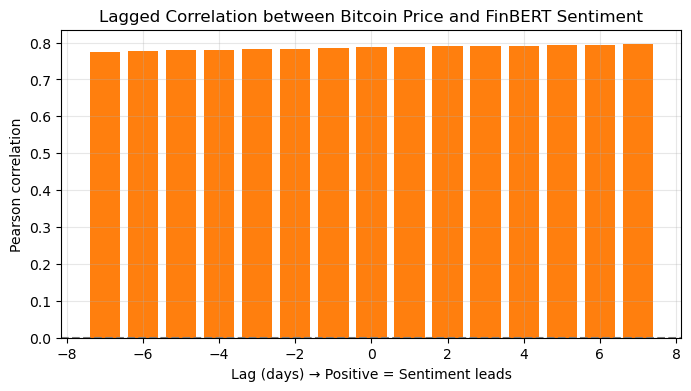

In [31]:
import matplotlib.pyplot as plt

lags, corrs = zip(*results)
plt.figure(figsize=(8,4))
plt.bar(lags, corrs, color='tab:orange')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Lagged Correlation between Bitcoin Price and FinBERT Sentiment")
plt.xlabel("Lag (days) → Positive = Sentiment leads")
plt.ylabel("Pearson correlation")
plt.grid(True, alpha=0.3)
plt.show()

In [34]:

merged['sentiment_value'] = merged['btc_close'] * (1 + 0.5 * merged['sentiment_normalized'])

# One-step-ahead forecasting test
merged['pred_next'] = merged['sentiment_value'].shift(1)
mae_fv = np.mean(abs(merged['btc_close'] - merged['btc_close'].shift(1)))         # naive FV forecast
mae_sent = np.mean(abs(merged['btc_close'] - merged['pred_next']))               # sentiment-adjusted
print(f"MAE FairValue: {mae_fv:.2f} | MAE Sentiment-Adjusted: {mae_sent:.2f}")


MAE FairValue: 880.57 | MAE Sentiment-Adjusted: 20535.47


In [35]:
import statsmodels.api as sm
import numpy as np

# --- Proxy fair value if not available ---
if 'btc_fair_value' not in merged.columns:
    merged['btc_fair_value'] = merged['btc_close'].shift(1)

# --- Sentiment-adjusted term ---
merged['fv_sent_adj'] = merged['btc_fair_value'] * (1 + merged['sentiment_normalized'])

# Drop missing
data = merged.dropna(subset=['btc_close', 'btc_fair_value', 'sentiment_normalized', 'fv_sent_adj']).copy()

# --- Model 1: Fair Value only ---
X1 = sm.add_constant(data['btc_fair_value'])
y = data['btc_close']
model_fv = sm.OLS(y, X1).fit()

# --- Model 2: Fair Value + Sentiment interaction ---
X2 = sm.add_constant(data[['btc_fair_value', 'fv_sent_adj']])
model_sent = sm.OLS(y, X2).fit()

print("⚙️ Fair Value model summary:")
print(model_fv.summary())

print("\n⚙️ Sentiment-Adjusted Fair Value model summary:")
print(model_sent.summary())


⚙️ Fair Value model summary:
                            OLS Regression Results                            
Dep. Variable:              btc_close   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 9.919e+05
Date:                Tue, 07 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:33:35   Log-Likelihood:                -18965.
No. Observations:                2186   AIC:                         3.793e+04
Df Residuals:                    2184   BIC:                         3.795e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          

In [36]:
# One-step-ahead forecasts
data['pred_fv'] = model_fv.predict(X1)
data['pred_sent'] = model_sent.predict(X2)

# Compute Mean Absolute Errors
mae_fv = np.mean(abs(data['btc_close'] - data['pred_fv']))
mae_sent = np.mean(abs(data['btc_close'] - data['pred_sent']))

print(f"MAE FairValue model: {mae_fv:.2f}")
print(f"MAE Sentiment-Adjusted model: {mae_sent:.2f}")

# Compare R² improvement
r2_gain = model_sent.rsquared - model_fv.rsquared
print(f"ΔR² (Sentiment – FV): {r2_gain:.4f}")


MAE FairValue model: 882.13
MAE Sentiment-Adjusted model: 886.36
ΔR² (Sentiment – FV): 0.0000


In [37]:
# Define ±3-day event window around each date
event_window = 3
merged['return'] = merged['btc_close'].pct_change()

event_sentiment = []
for i, row in merged.iterrows():
    if abs(row['sentiment_normalized']) > 1:  # “strong” sentiment spikes
        window = merged.iloc[max(0, i-event_window):i+event_window+1]
        car = window['return'].sum()
        event_sentiment.append({'date': row['date'], 'CAR': car, 'sent': row['sentiment_normalized']})

event_df = pd.DataFrame(event_sentiment)
print(event_df.corr())


          date       CAR      sent
date  1.000000  0.046798  0.817077
CAR   0.046798  1.000000  0.134526
sent  0.817077  0.134526  1.000000


In [39]:
pip install arch

   ---------------------------------------- 0.0/926.2 kB ? eta -:--:--
   ---------------------------------------- 926.2/926.2 kB 8.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
